# Gap junction model between LIF neurons

In [1]:
from brian2 import *
from brian2 import __version__
print(__version__)

2.3


In [2]:
seed(12345)
prefs.codegen.target = "numpy"

In [3]:
import matplotlib.patches as patches
import npbrain.all as nn

In [4]:
gj_w, k_spikelet = 1., 0.5
size = (10, 10)
Vr = 0.
Vth = 10.
tau = 10 * ms
Iext = 12.
noise = 1.
duration = 500

In [5]:
eqs = '''
    dV/dt = (-V + Vr + Igap + Iext + sqrt(1*ms) * noise * xi) / tau : 1
    Igap : 1 # gap junction current
'''
neurons = NeuronGroup(size[0] * size[1], eqs, threshold='V>Vth', reset='V=Vr', method='euler')
neurons.V = 'rand() * (Vth - Vr) + Vr'

In [6]:
S = Synapses(source=neurons,
             target=neurons,
             model='''w : 1 # gap junction conductance
                      Igap_post = w * (V_pre - V_post) : 1 (summed)''',
             on_pre='V_post += w * {}'.format(k_spikelet))
pre_index, post_index, _ = nn.conn.grid_four(size[0], size[1])
S.connect(i=pre_index, j=post_index)
S.w = gj_w

In [7]:
mon_st = StateMonitor(neurons, 'V', record=True)
mon_sp = SpikeMonitor(neurons, record=True)
run(duration * ms)

In [9]:
neuron_indexes = [1]
spike_trains = mon_sp.spike_trains()

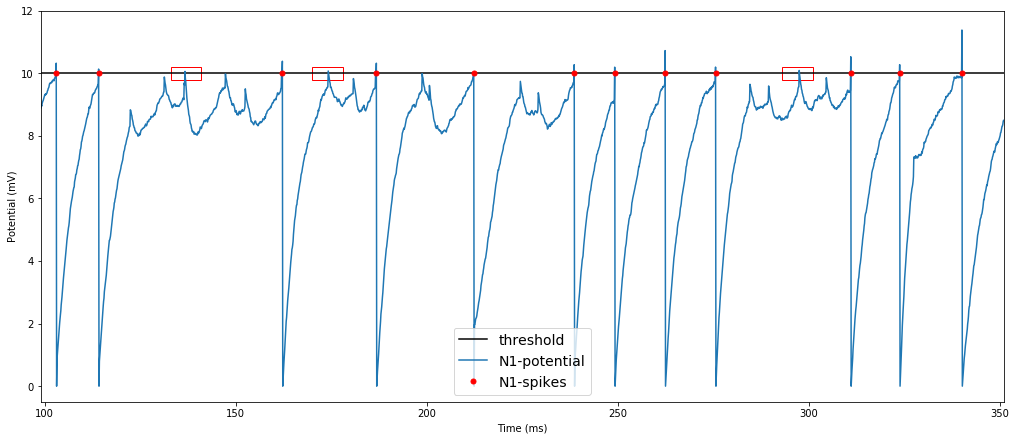

In [10]:
fig, gs = nn.vis.get_figure(1, 1, 6, 14)
ax = fig.add_subplot(gs[0, 0])
ax.plot([0, duration], [Vth, Vth], 'k', label='threshold')
for i in neuron_indexes:
    ax.plot(mon_st.t / ms, mon_st.V[i], label='N{}-potential'.format(i))
    spikes = spike_trains[1] / ms
    ax.plot(spikes, np.ones_like(spikes) * Vth, '.r', markersize=10, label='N{}-spikes'.format(i))
    ax.add_patch(patches.Rectangle((133, 9.8), 8, 0.4, linewidth=1, edgecolor='r', facecolor='none'))
    ax.add_patch(patches.Rectangle((170, 9.8), 8, 0.4, linewidth=1, edgecolor='r', facecolor='none'))
    ax.add_patch(patches.Rectangle((293, 9.8), 8, 0.4, linewidth=1, edgecolor='r', facecolor='none'))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Potential (mV)')
ax.legend(loc='lower center', fontsize=14)
xlim(99, 351)
ylim(-0.5, 12.)
show()